## BeCoMe Visualizations -  Results Analysis

This file contains visualizations for demonstrating the BeCoMe algorithm
(Best Compromise Method) on three example datasets:
- Budget Case: COVID-19 budget estimates (22 experts)
- Floods Case: arable land reduction for flood prevention (13 experts)
- Pendlers Case: cross-border worker travel assessment using Likert scale (22 experts)

In [25]:
# Imports
import os
import sys
from pathlib import Path

import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.gridspec import GridSpec

# Add project root to Python path for imports to work
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

# Define paths
data_dir = Path(os.getcwd()) / ".." / "data"
output_dir = Path(os.getcwd()) / "output"

from examples.utils import calculate_agreement_level, load_data_from_txt
from src.calculators.become_calculator import BeCoMeCalculator

# Plot settings
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## 1. Data Loading

Load all three datasets and compute BeCoMe results

In [26]:
# Budget Case
budget_opinions, budget_metadata = load_data_from_txt(str(data_dir / "budget_case.txt"))
budget_calculator = BeCoMeCalculator()
budget_result = budget_calculator.calculate_compromise(budget_opinions)

# Floods Case
floods_opinions, floods_metadata = load_data_from_txt(str(data_dir / "floods_case.txt"))
floods_calculator = BeCoMeCalculator()
floods_result = floods_calculator.calculate_compromise(floods_opinions)

# Pendlers Case
pendlers_opinions, pendlers_metadata = load_data_from_txt(str(data_dir / "pendlers_case.txt"))
pendlers_calculator = BeCoMeCalculator()
pendlers_result = pendlers_calculator.calculate_compromise(pendlers_opinions)

print("Data loaded:")
print(f"  Budget: {len(budget_opinions)} experts, delta_max = {budget_result.max_error:.2f}")
print(f"  Floods: {len(floods_opinions)} experts, delta_max = {floods_result.max_error:.2f}")
print(f"  Pendlers: {len(pendlers_opinions)} experts, delta_max = {pendlers_result.max_error:.2f}")

Data loaded:
  Budget: 22 experts, delta_max = 2.20
  Floods: 13 experts, delta_max = 5.97
  Pendlers: 22 experts, delta_max = 5.68


## 2. Visualization 

### 1: Triangular Membership Functions

Display triangular membership functions for all experts with overlaid curves for arithmetic mean, median, and "best compromise".

Shows how aggregation compresses the distribution of opinions.

In [27]:
def plot_triangular_membership_functions(opinions, result, title, case_name):
    """
    Plot triangular membership functions for all experts
    with overlaid aggregated results
    """
    _fig, ax = plt.subplots(figsize=(14, 7))

    # Color scheme
    expert_color = "lightblue"
    expert_alpha = 0.3
    mean_color = "#FF6B6B"
    median_color = "#4ECDC4"
    compromise_color = "#FFD93D"

    # Draw triangles for all experts
    for opinion in opinions:
        lower = opinion.opinion.lower_bound
        peak = opinion.opinion.peak
        upper = opinion.opinion.upper_bound

        # Triangle: (lower, 0) -> (peak, 1) -> (upper, 0)
        x = [lower, peak, upper, lower]
        y = [0, 1, 0, 0]
        ax.fill(x, y, color=expert_color, alpha=expert_alpha, edgecolor="gray", linewidth=0.5)

    # Function to draw aggregated triangle
    def draw_aggregate_triangle(fuzzy_num, color, label, linewidth=3):
        x = [fuzzy_num.lower_bound, fuzzy_num.peak, fuzzy_num.upper_bound, fuzzy_num.lower_bound]
        y = [0, 1, 0, 0]
        ax.plot(x, y, color=color, linewidth=linewidth, label=label, zorder=5)
        ax.fill(x, y, color=color, alpha=0.15, zorder=4)

    # Draw aggregated results
    draw_aggregate_triangle(result.arithmetic_mean, mean_color, "Arithmetic Mean (Gamma)")
    draw_aggregate_triangle(result.median, median_color, "Median (Omega)")
    draw_aggregate_triangle(
        result.best_compromise, compromise_color, "Best Compromise (GammaOmegaMean)"
    )

    ax.set_xlabel("Value", fontsize=12, fontweight="bold")
    ax.set_ylabel("Membership Degree mu(x)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"{title}\nTriangular Membership Functions ({len(opinions)} experts)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylim(-0.05, 1.1)
    ax.legend(fontsize=11, loc="upper right")
    ax.grid(True, alpha=0.3)

    # Add patch for individual expert opinions in legend
    expert_patch = mpatches.Patch(
        facecolor=expert_color, alpha=expert_alpha, edgecolor="gray", label="Expert Opinions"
    )
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, expert_patch)
    labels.insert(0, "Expert Opinions")
    ax.legend(handles, labels, fontsize=11, loc="upper right")

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_membership_functions.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

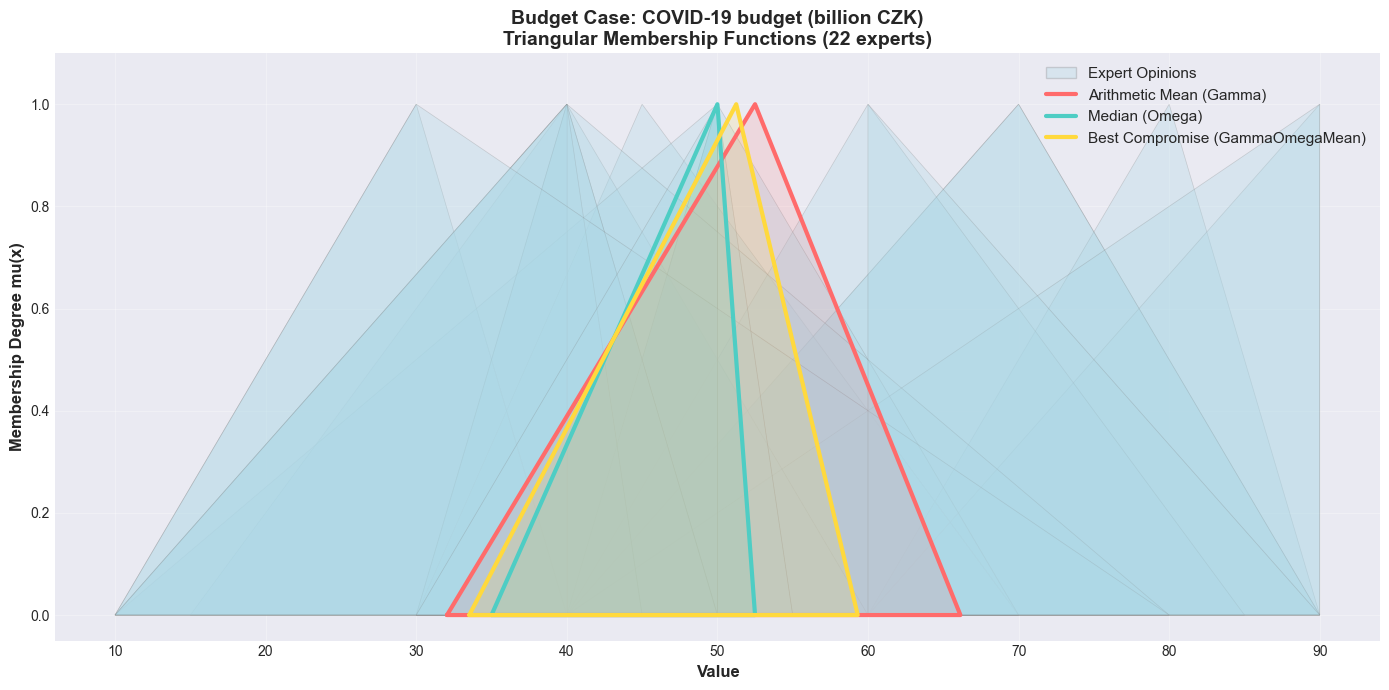

In [28]:
plot_triangular_membership_functions(
    budget_opinions, budget_result, "Budget Case: COVID-19 budget (billion CZK)", "budget"
)

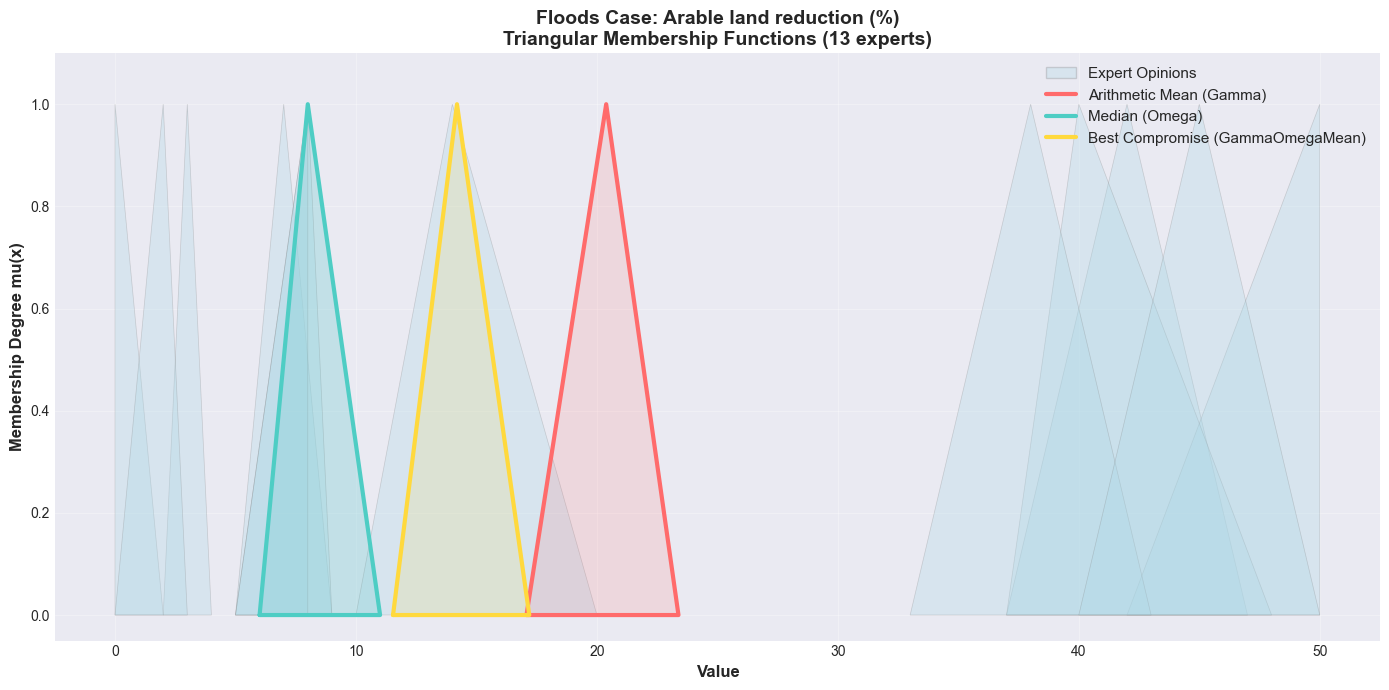

In [29]:
plot_triangular_membership_functions(
    floods_opinions, floods_result, "Floods Case: Arable land reduction (%)", "floods"
)

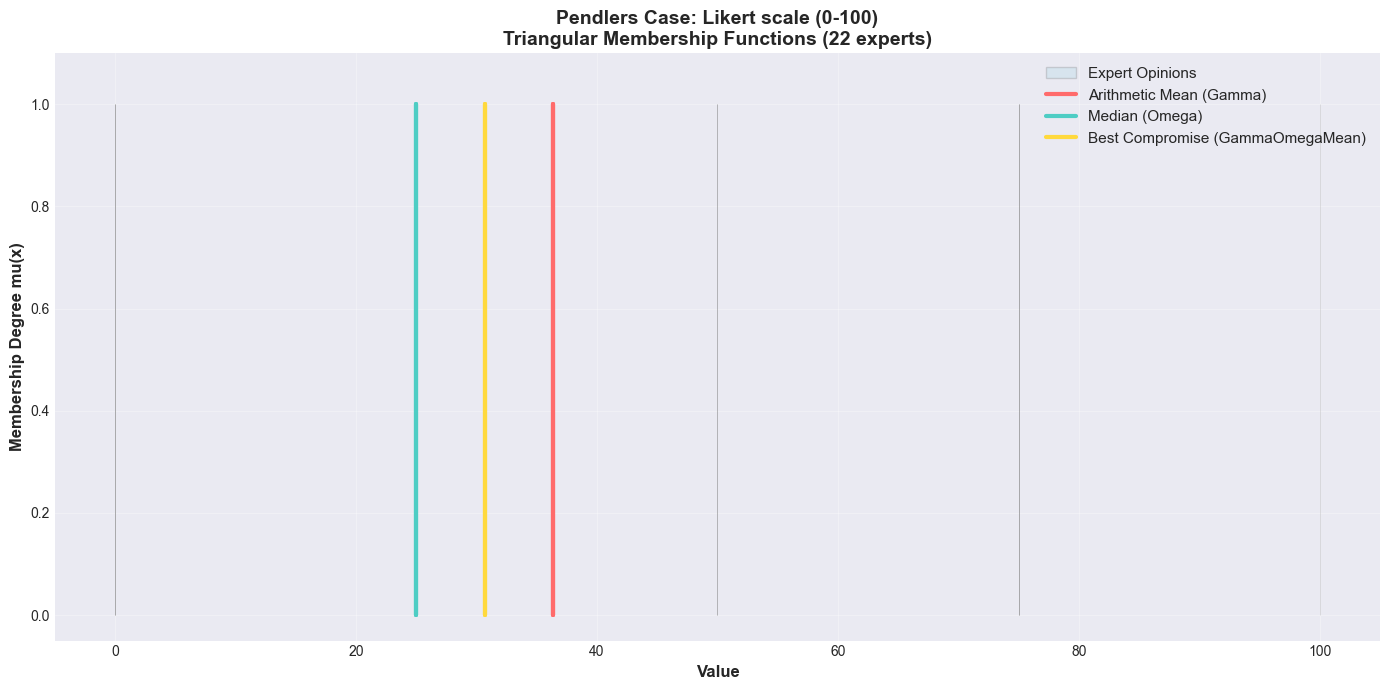

In [30]:
plot_triangular_membership_functions(
    pendlers_opinions, pendlers_result, "Pendlers Case: Likert scale (0-100)", "pendlers"
)

## 2. Visualization 

### 2: Centroid Chart

Bar chart with experts sorted by centroids.

Centroids of mean and median values are highlighted.

Delta_max is displayed as half the distance between these points.

In [31]:
def plot_centroid_chart(opinions, result, title, case_name):
    """
    Centroid chart for experts with highlighted aggregated metrics
    """
    # Sort experts by centroid
    sorted_opinions = sorted(opinions, key=lambda op: op.centroid)

    expert_ids = [op.expert_id for op in sorted_opinions]
    centroids = [op.centroid for op in sorted_opinions]

    # Create DataFrame for convenience
    df = pd.DataFrame({"expert_id": expert_ids, "centroid": centroids})

    _fig, ax = plt.subplots(figsize=(14, 7))

    # Bars for experts
    ax.bar(
        range(len(df)),
        df["centroid"],
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    # Horizontal lines for aggregated values
    mean_centroid = result.arithmetic_mean.centroid
    median_centroid = result.median.centroid
    compromise_centroid = result.best_compromise.centroid

    ax.axhline(
        y=mean_centroid,
        color="#FF6B6B",
        linestyle="--",
        linewidth=2.5,
        label=f"Mean (Gamma): {mean_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=median_centroid,
        color="#4ECDC4",
        linestyle="--",
        linewidth=2.5,
        label=f"Median (Omega): {median_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=compromise_centroid,
        color="#FFD93D",
        linestyle="--",
        linewidth=2.5,
        label=f"Compromise (GammaOmegaMean): {compromise_centroid:.2f}",
        zorder=5,
    )

    # Display delta_max as distance
    delta_max = result.max_error

    # Add annotation for delta_max
    mid_point = (mean_centroid + median_centroid) / 2
    ax.annotate(
        "",
        xy=(len(df) * 0.95, mean_centroid),
        xytext=(len(df) * 0.95, median_centroid),
        arrowprops=dict(arrowstyle="<->", color="red", lw=2),
    )
    ax.text(
        len(df) * 0.97,
        mid_point,
        f"delta_max = {delta_max:.2f}",
        fontsize=11,
        color="red",
        fontweight="bold",
        verticalalignment="center",
    )

    ax.set_xlabel("Experts (sorted by centroid)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Centroid Value", fontsize=12, fontweight="bold")
    ax.set_title(f"{title}\nExpert Centroids and Aggregated Values", fontsize=14, fontweight="bold")
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df["expert_id"], rotation=45, ha="right")
    ax.legend(fontsize=11, loc="upper left")
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_centroids.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

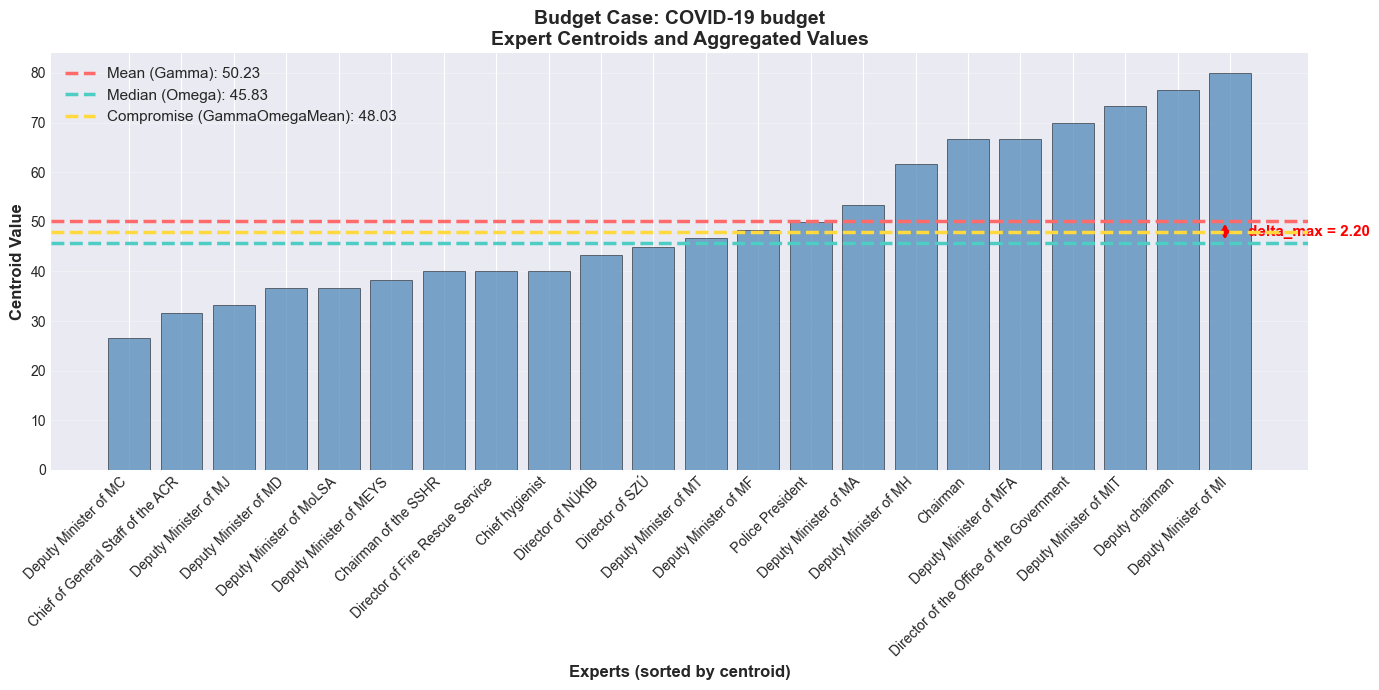

In [32]:
plot_centroid_chart(budget_opinions, budget_result, "Budget Case: COVID-19 budget", "budget")

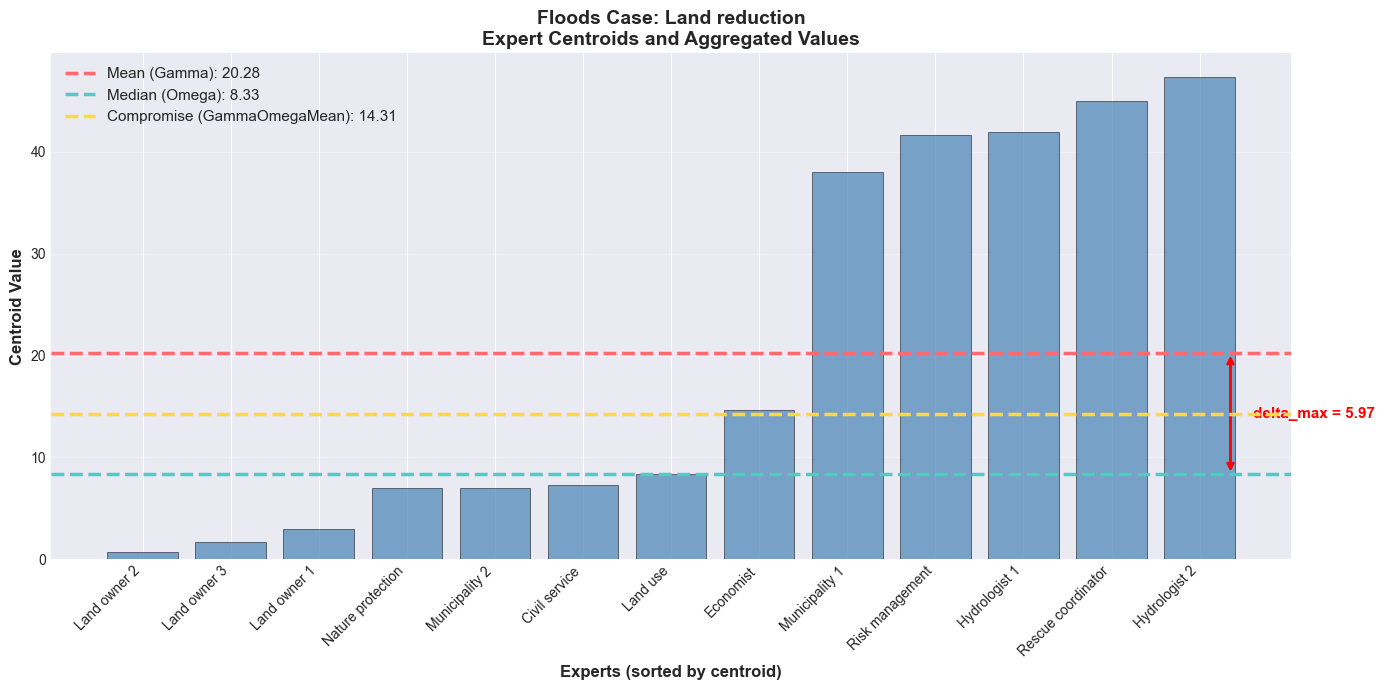

In [33]:
plot_centroid_chart(floods_opinions, floods_result, "Floods Case: Land reduction", "floods")

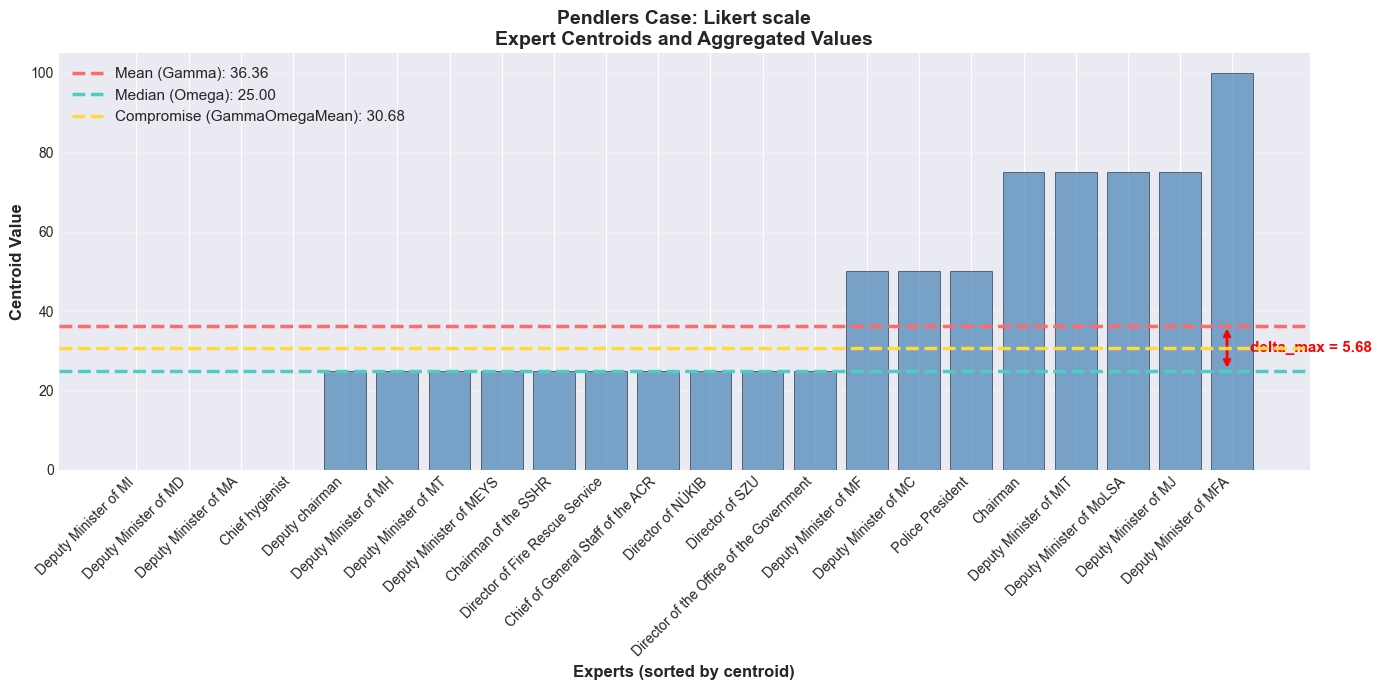

In [34]:
plot_centroid_chart(pendlers_opinions, pendlers_result, "Pendlers Case: Likert scale", "pendlers")

## 2. Visualization 

### 3: Range Comparison (Heatmap)

Heatmap showing lower, peak, and upper values for each expert and for final aggregates. Helps identify consensus zone.

In [35]:
def plot_range_comparison_heatmap(opinions, result, title, case_name):
    """
    Heatmap of expert opinion ranges
    """
    # Prepare data
    data = []
    for op in sorted(opinions, key=lambda x: x.centroid):
        data.append(
            {
                "Expert": op.expert_id,
                "Lower": op.opinion.lower_bound,
                "Peak": op.opinion.peak,
                "Upper": op.opinion.upper_bound,
            }
        )

    # Add aggregated results
    data.append(
        {
            "Expert": "--- Mean (Gamma) ---",
            "Lower": result.arithmetic_mean.lower_bound,
            "Peak": result.arithmetic_mean.peak,
            "Upper": result.arithmetic_mean.upper_bound,
        }
    )
    data.append(
        {
            "Expert": "--- Median (Omega) ---",
            "Lower": result.median.lower_bound,
            "Peak": result.median.peak,
            "Upper": result.median.upper_bound,
        }
    )
    data.append(
        {
            "Expert": "=== Compromise ===",
            "Lower": result.best_compromise.lower_bound,
            "Peak": result.best_compromise.peak,
            "Upper": result.best_compromise.upper_bound,
        }
    )

    df = pd.DataFrame(data)
    df_values = df[["Lower", "Peak", "Upper"]].values

    _fig, ax = plt.subplots(figsize=(10, len(df) * 0.4))

    # Heatmap
    im = ax.imshow(df_values, cmap="RdYlGn_r", aspect="auto")

    # Axis settings
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["Lower", "Peak", "Upper"], fontsize=11, fontweight="bold")
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df["Expert"], fontsize=9)

    # Add values to cells
    for i in range(len(df)):
        for j in range(3):
            ax.text(
                j, i, f"{df_values[i, j]:.1f}", ha="center", va="center", color="black", fontsize=8
            )

    # Highlight aggregated results
    for i in range(len(opinions), len(df)):
        ax.add_patch(
            plt.Rectangle((-0.5, i - 0.5), 3, 1, fill=False, edgecolor="blue", linewidth=2)
        )

    ax.set_title(
        f"{title}\nRange Comparison (Lower-Peak-Upper)", fontsize=14, fontweight="bold", pad=20
    )

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label("Value", rotation=270, labelpad=20, fontsize=11)

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_heatmap.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

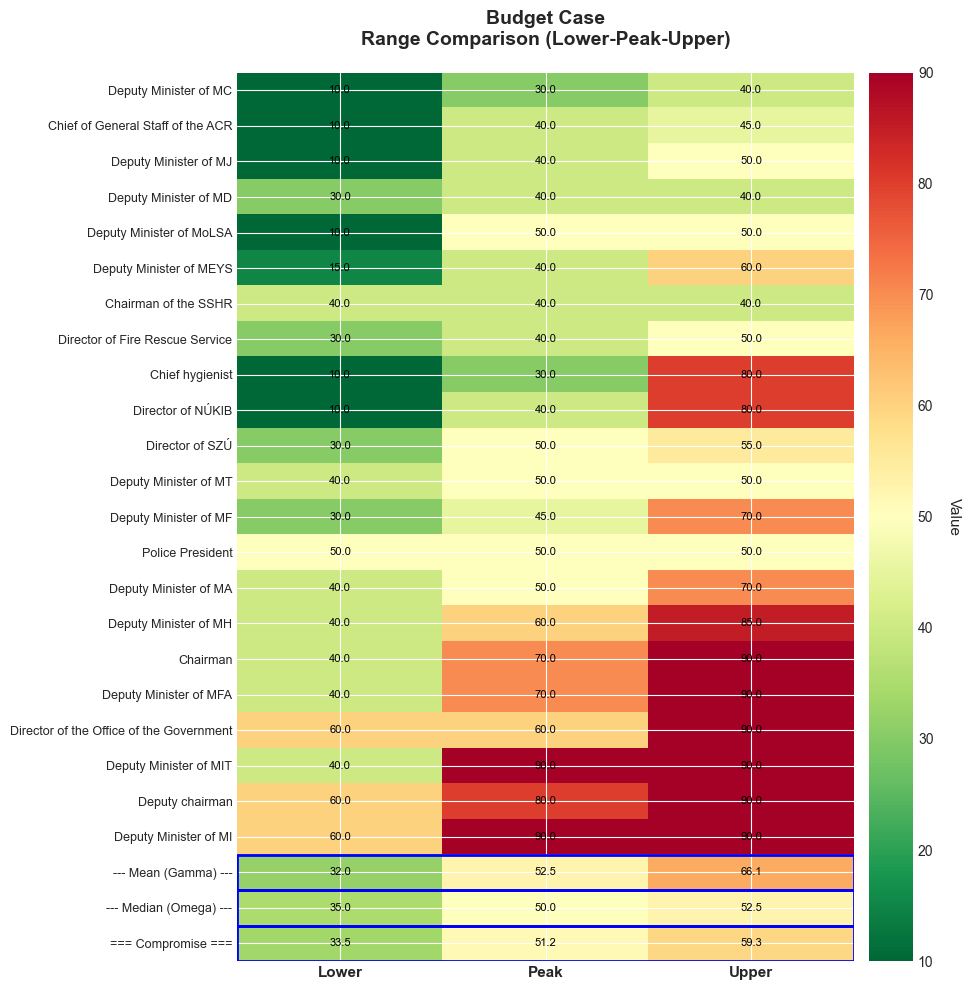

In [36]:
plot_range_comparison_heatmap(budget_opinions, budget_result, "Budget Case", "budget")

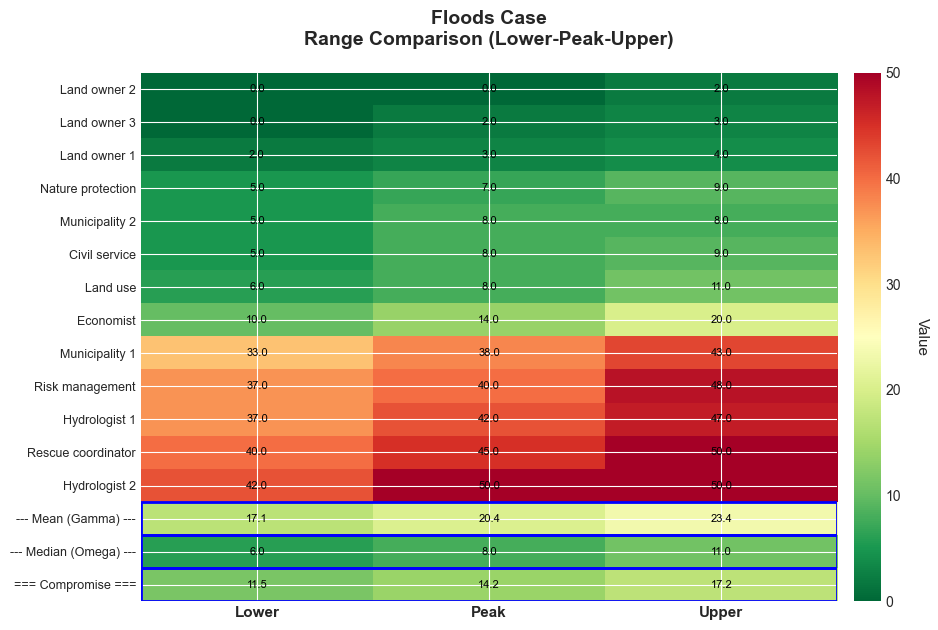

In [37]:
plot_range_comparison_heatmap(floods_opinions, floods_result, "Floods Case", "floods")

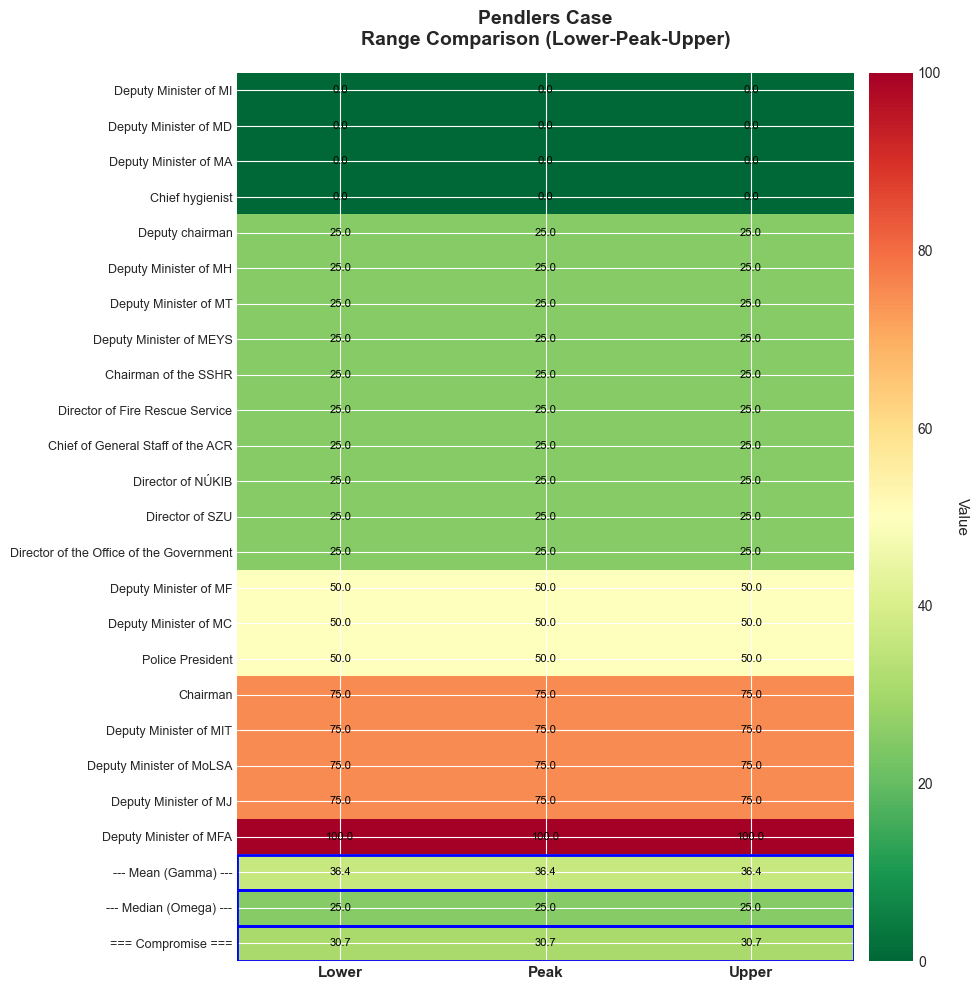

In [38]:
plot_range_comparison_heatmap(pendlers_opinions, pendlers_result, "Pendlers Case", "pendlers")

## 2. Visualization 

### 4: Interactive Sensitivity Analysis

ipywidgets for including/excluding individual experts. 

Upon each change, aggregates are recalculated and plots are updated, demonstrating method robustness.

In [39]:
def create_sensitivity_analysis_widget(opinions, title, case_name):
    """
    Interactive widget for sensitivity analysis
    """
    # Create checkboxes for each expert
    checkboxes = {}
    for op in opinions:
        checkboxes[op.expert_id] = widgets.Checkbox(
            value=True,
            description=f"{op.expert_id} (c={op.centroid:.1f})",
            style={"description_width": "initial"},
            layout=widgets.Layout(width="200px"),
        )

    # Output widget for plots
    output = widgets.Output()

    def update_plot(change=None):
        """Update plot when expert selection changes"""
        # Get list of selected experts
        selected_opinions = [op for op in opinions if checkboxes[op.expert_id].value]

        if len(selected_opinions) < 2:
            with output:
                output.clear_output(wait=True)
                print("WARNING: Select at least 2 experts for calculation")
            return

        # Recalculate results
        calculator = BeCoMeCalculator()
        result = calculator.calculate_compromise(selected_opinions)

        with output:
            output.clear_output(wait=True)

            _fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            # Plot 1: Triangular functions
            expert_color = "lightblue"
            for op in selected_opinions:
                x = [
                    op.opinion.lower_bound,
                    op.opinion.peak,
                    op.opinion.upper_bound,
                    op.opinion.lower_bound,
                ]
                y = [0, 1, 0, 0]
                ax1.fill(x, y, color=expert_color, alpha=0.3, edgecolor="gray", linewidth=0.5)

            # Aggregates
            for fuzzy_num, color, label in [
                (result.arithmetic_mean, "#FF6B6B", "Mean"),
                (result.median, "#4ECDC4", "Median"),
                (result.best_compromise, "#FFD93D", "Compromise"),
            ]:
                x = [
                    fuzzy_num.lower_bound,
                    fuzzy_num.peak,
                    fuzzy_num.upper_bound,
                    fuzzy_num.lower_bound,
                ]
                y = [0, 1, 0, 0]
                ax1.plot(x, y, color=color, linewidth=2.5, label=label)

            ax1.set_xlabel("Value", fontweight="bold")
            ax1.set_ylabel("Membership Degree mu(x)", fontweight="bold")
            ax1.set_title(
                f"Membership Functions ({len(selected_opinions)} experts)", fontweight="bold"
            )
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(-0.05, 1.1)

            # Plot 2: Centroids
            sorted_ops = sorted(selected_opinions, key=lambda x: x.centroid)
            centroids = [op.centroid for op in sorted_ops]
            expert_ids = [op.expert_id for op in sorted_ops]

            ax2.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7)
            ax2.axhline(
                y=result.arithmetic_mean.centroid,
                color="#FF6B6B",
                linestyle="--",
                linewidth=2,
                label="Mean",
            )
            ax2.axhline(
                y=result.median.centroid,
                color="#4ECDC4",
                linestyle="--",
                linewidth=2,
                label="Median",
            )
            ax2.axhline(
                y=result.best_compromise.centroid,
                color="#FFD93D",
                linestyle="--",
                linewidth=2,
                label="Compromise",
            )

            ax2.set_xlabel("Experts", fontweight="bold")
            ax2.set_ylabel("Centroid", fontweight="bold")
            ax2.set_title(f"Centroids (delta_max = {result.max_error:.2f})", fontweight="bold")
            ax2.set_xticks(range(len(expert_ids)))
            ax2.set_xticklabels(expert_ids, rotation=45, ha="right")
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis="y")

            plt.tight_layout()
            plt.show()

            # Display metrics
            agreement = calculate_agreement_level(result.max_error, (5.0, 15.0))
            print(f"\nMetrics ({len(selected_opinions)} experts):")
            print(f"   delta_max = {result.max_error:.2f} ({agreement})")
            print(
                f"   Compromise: [{result.best_compromise.lower_bound:.2f}, "
                f"{result.best_compromise.peak:.2f}, {result.best_compromise.upper_bound:.2f}]"
            )
            print(f"   Compromise centroid: {result.best_compromise.centroid:.2f}")

    # Bind event handlers
    for checkbox in checkboxes.values():
        checkbox.observe(update_plot, names="value")

    # Initial drawing
    update_plot()

    # Layout widgets
    checkbox_cols = []
    items_per_col = 8
    checkbox_list = list(checkboxes.values())

    for i in range(0, len(checkbox_list), items_per_col):
        checkbox_cols.append(widgets.VBox(checkbox_list[i : i + items_per_col]))

    controls = widgets.HBox(checkbox_cols)

    title_widget = widgets.HTML(f"<h3>{title} - Sensitivity Analysis</h3>")
    info_widget = widgets.HTML(
        "<p><i>Select/deselect experts to see the impact on BeCoMe results</i></p>"
    )

    display(widgets.VBox([title_widget, info_widget, controls, output]))

In [40]:
print("Budget Case - Interactive Analysis:")
create_sensitivity_analysis_widget(budget_opinions, "Budget Case: COVID-19 budget", "budget")

Budget Case - Interactive Analysis:


In [41]:
print("\nFloods Case - Interactive Analysis:")
create_sensitivity_analysis_widget(floods_opinions, "Floods Case: Land reduction", "floods")


Floods Case - Interactive Analysis:


In [42]:
print("\nPendlers Case - Interactive Analysis:")
create_sensitivity_analysis_widget(pendlers_opinions, "Pendlers Case: Likert scale", "pendlers")


Pendlers Case - Interactive Analysis:


## 2. Visualization 

### 5: Scenario Dashboard

Table with key metrics (centroids, delta_max, ranges) and mini-charts for Budget, Floods, Pendlers cases. Facilitates scenario comparison.

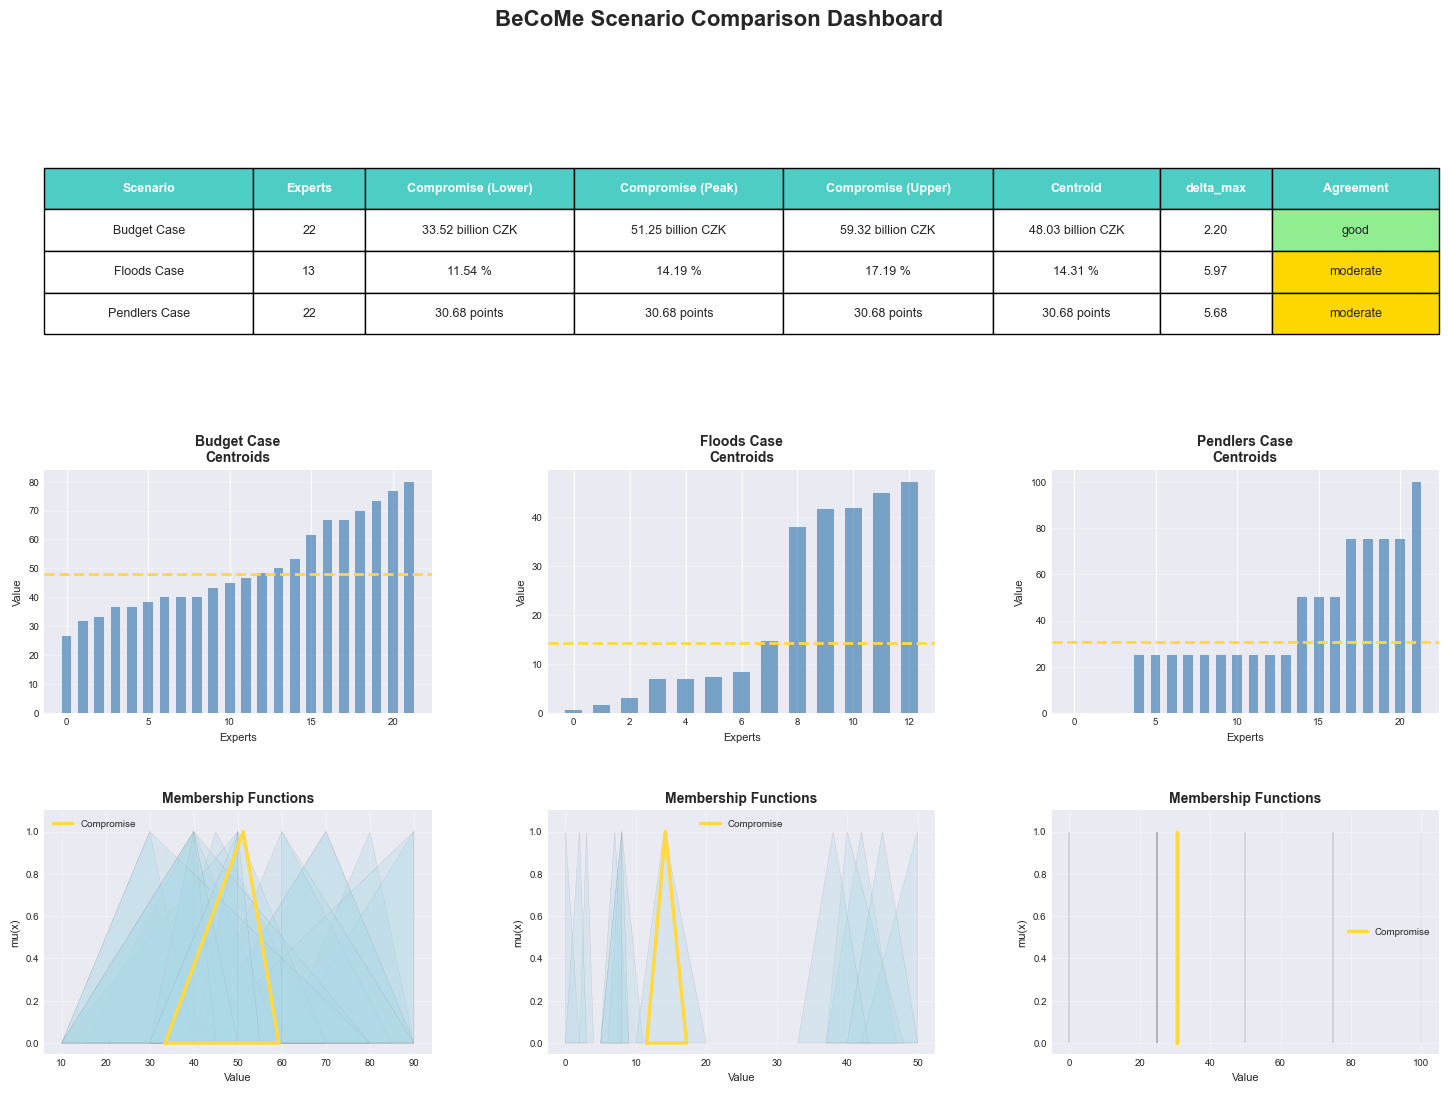


SCENARIO METRICS SUMMARY
     Scenario  Experts Compromise (Lower) Compromise (Peak) Compromise (Upper)          Centroid delta_max Agreement
  Budget Case       22  33.52 billion CZK 51.25 billion CZK  59.32 billion CZK 48.03 billion CZK      2.20      good
  Floods Case       13            11.54 %           14.19 %            17.19 %           14.31 %      5.97  moderate
Pendlers Case       22       30.68 points      30.68 points       30.68 points      30.68 points      5.68  moderate


In [43]:
def create_scenario_dashboard():
    """
    Dashboard for comparing all three scenarios
    """
    # Prepare data for metrics table
    scenarios = [
        ("Budget Case", budget_result, len(budget_opinions), "billion CZK"),
        ("Floods Case", floods_result, len(floods_opinions), "%"),
        ("Pendlers Case", pendlers_result, len(pendlers_opinions), "points"),
    ]

    metrics_data = []
    for name, result, num_experts, unit in scenarios:
        agreement = calculate_agreement_level(result.max_error, (5.0, 15.0))
        metrics_data.append(
            {
                "Scenario": name,
                "Experts": num_experts,
                "Compromise (Lower)": f"{result.best_compromise.lower_bound:.2f} {unit}",
                "Compromise (Peak)": f"{result.best_compromise.peak:.2f} {unit}",
                "Compromise (Upper)": f"{result.best_compromise.upper_bound:.2f} {unit}",
                "Centroid": f"{result.best_compromise.centroid:.2f} {unit}",
                "delta_max": f"{result.max_error:.2f}",
                "Agreement": agreement,
            }
        )

    df_metrics = pd.DataFrame(metrics_data)

    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

    # Title
    fig.suptitle("BeCoMe Scenario Comparison Dashboard", fontsize=16, fontweight="bold", y=0.98)

    # Metrics table (occupies entire first row)
    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis("tight")
    ax_table.axis("off")

    table = ax_table.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.15, 0.08, 0.15, 0.15, 0.15, 0.12, 0.08, 0.12],
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)

    # Table styling
    for i in range(len(df_metrics.columns)):
        table[(0, i)].set_facecolor("#4ECDC4")
        table[(0, i)].set_text_props(weight="bold", color="white")

    for i in range(1, len(df_metrics) + 1):
        for j in range(len(df_metrics.columns)):
            if j == len(df_metrics.columns) - 1:  # Agreement column
                agreement_level = df_metrics.iloc[i - 1, j]
                if agreement_level == "good":
                    table[(i, j)].set_facecolor("#90EE90")
                elif agreement_level == "moderate":
                    table[(i, j)].set_facecolor("#FFD700")
                else:
                    table[(i, j)].set_facecolor("#FFB6C1")

    # Mini-charts for each scenario
    scenarios_data = [
        (budget_opinions, budget_result, "Budget Case", 0),
        (floods_opinions, floods_result, "Floods Case", 1),
        (pendlers_opinions, pendlers_result, "Pendlers Case", 2),
    ]

    for opinions, result, name, col_idx in scenarios_data:
        # Centroid chart (upper row)
        ax1 = fig.add_subplot(gs[1, col_idx])
        sorted_ops = sorted(opinions, key=lambda x: x.centroid)
        centroids = [op.centroid for op in sorted_ops]

        ax1.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7, width=0.6)
        ax1.axhline(y=result.best_compromise.centroid, color="#FFD93D", linestyle="--", linewidth=2)
        ax1.set_title(f"{name}\nCentroids", fontsize=10, fontweight="bold")
        ax1.set_xlabel("Experts", fontsize=8)
        ax1.set_ylabel("Value", fontsize=8)
        ax1.tick_params(labelsize=7)
        ax1.grid(True, alpha=0.3, axis="y")

        # Triangular functions chart (lower row)
        ax2 = fig.add_subplot(gs[2, col_idx])

        for op in opinions:
            x = [
                op.opinion.lower_bound,
                op.opinion.peak,
                op.opinion.upper_bound,
                op.opinion.lower_bound,
            ]
            y = [0, 1, 0, 0]
            ax2.fill(x, y, color="lightblue", alpha=0.3, edgecolor="gray", linewidth=0.3)

        # Compromise
        x = [
            result.best_compromise.lower_bound,
            result.best_compromise.peak,
            result.best_compromise.upper_bound,
            result.best_compromise.lower_bound,
        ]
        y = [0, 1, 0, 0]
        ax2.plot(x, y, color="#FFD93D", linewidth=2.5, label="Compromise")

        ax2.set_title("Membership Functions", fontsize=10, fontweight="bold")
        ax2.set_xlabel("Value", fontsize=8)
        ax2.set_ylabel("mu(x)", fontsize=8)
        ax2.tick_params(labelsize=7)
        ax2.legend(fontsize=7)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-0.05, 1.1)

    plt.savefig(
        output_dir / "scenario_dashboard.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Additionally print table to console
    print("\n" + "=" * 100)
    print("SCENARIO METRICS SUMMARY")
    print("=" * 100)
    print(df_metrics.to_string(index=False))
    print("=" * 100)


create_scenario_dashboard()

## 2. Visualization 

### 6: Accuracy Gauge Indicator

"Speedometer" or bar chart with quality thresholds (good / moderate / low) for delta_max, allowing instant assessment of expert agreement level.

In [44]:
def plot_accuracy_gauge(result, title, case_name, thresholds=(5.0, 15.0)):
    """
    Accuracy indicator as gauge (speedometer) for delta_max
    """
    delta_max = result.max_error
    agreement = calculate_agreement_level(delta_max, thresholds)

    # Determine color and range
    if agreement == "good":
        color = "#2ECC71"  # Green
        gauge_value = min(delta_max / thresholds[0], 1.0)
        zone = "EXCELLENT AGREEMENT"
    elif agreement == "moderate":
        color = "#F39C12"  # Orange
        gauge_value = 0.5 + 0.5 * min(
            (delta_max - thresholds[0]) / (thresholds[1] - thresholds[0]), 1.0
        )
        zone = "MODERATE AGREEMENT"
    else:
        color = "#E74C3C"  # Red
        gauge_value = min(delta_max / (thresholds[1] * 1.5), 1.0)
        zone = "LOW AGREEMENT"

    # Create figure with two plots
    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1.2, 1])

    # Plot 1: Gauge (semicircle speedometer)
    ax1 = fig.add_subplot(gs[0])

    # Draw semicircle with zones
    # Zones: good (0-pi/3), moderate (pi/3-2pi/3), low (2pi/3-pi)
    zone_ranges = [
        (0, np.pi / 3, "#2ECC71", "Good"),
        (np.pi / 3, 2 * np.pi / 3, "#F39C12", "Moderate"),
        (2 * np.pi / 3, np.pi, "#E74C3C", "Low"),
    ]

    # Draw outer zones
    for start, end, col, _label in zone_ranges:
        theta_zone = np.linspace(start, end, 100)
        x_outer = np.cos(theta_zone)
        y_outer = np.sin(theta_zone)
        x_inner = 0.7 * np.cos(theta_zone)
        y_inner = 0.7 * np.sin(theta_zone)

        # Create polygon for the zone
        vertices = list(zip(x_outer, y_outer, strict=False)) + list(
            zip(x_inner[::-1], y_inner[::-1], strict=False)
        )
        poly = plt.Polygon(vertices, color=col, alpha=0.3, edgecolor=col, linewidth=0)
        ax1.add_patch(poly)

    # Draw white inner circle once
    theta_inner = np.linspace(0, np.pi, 200)
    x_inner_circle = 0.7 * np.cos(theta_inner)
    y_inner_circle = 0.7 * np.sin(theta_inner)
    ax1.fill(
        [*x_inner_circle, x_inner_circle[-1], x_inner_circle[0]],
        [*y_inner_circle, 0, 0],
        color="white",
        zorder=2,
    )

    # Arrow (indicator)
    angle = np.pi * (1 - gauge_value)
    arrow_length = 0.85
    ax1.arrow(
        0,
        0,
        arrow_length * np.cos(angle),
        arrow_length * np.sin(angle),
        head_width=0.1,
        head_length=0.1,
        fc=color,
        ec=color,
        linewidth=3,
        zorder=5,
    )

    # Central circle
    circle = plt.Circle((0, 0), 0.15, color="black", zorder=10)
    ax1.add_patch(circle)

    # Text with delta_max value
    ax1.text(
        0,
        -0.3,
        f"delta_max = {delta_max:.2f}",
        ha="center",
        va="top",
        fontsize=18,
        fontweight="bold",
        color=color,
    )
    ax1.text(0, -0.45, zone, ha="center", va="top", fontsize=12, fontweight="bold", color=color)

    # Zone labels
    ax1.text(
        -0.85, 0.5, "Good\n(< 5.0)", ha="center", fontsize=9, color="#2ECC71", fontweight="bold"
    )
    ax1.text(
        0, 1.05, "Moderate\n(5.0-15.0)", ha="center", fontsize=9, color="#F39C12", fontweight="bold"
    )
    ax1.text(
        0.85, 0.5, "Low\n(> 15.0)", ha="center", fontsize=9, color="#E74C3C", fontweight="bold"
    )

    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-0.6, 1.3)
    ax1.set_aspect("equal")
    ax1.axis("off")
    ax1.set_title(
        f"{title}\nExpert Agreement Quality Indicator", fontsize=12, fontweight="bold", pad=20
    )

    # Plot 2: Bar chart with thresholds
    ax2 = fig.add_subplot(gs[1])

    ax2.barh(["delta_max"], [delta_max], color=color, height=0.5, edgecolor="black", linewidth=2)

    # Threshold lines
    ax2.axvline(
        x=thresholds[0], color="#2ECC71", linestyle="--", linewidth=2, label="Good Threshold"
    )
    ax2.axvline(
        x=thresholds[1], color="#E74C3C", linestyle="--", linewidth=2, label="Low Threshold"
    )

    # Background zones
    ax2.axvspan(0, thresholds[0], alpha=0.2, color="#2ECC71")
    ax2.axvspan(thresholds[0], thresholds[1], alpha=0.2, color="#F39C12")
    ax2.axvspan(
        thresholds[1], max(delta_max * 1.2, thresholds[1] * 1.2), alpha=0.2, color="#E74C3C"
    )

    ax2.set_xlabel("delta_max Value", fontsize=11, fontweight="bold")
    ax2.set_title("delta_max Relative to Thresholds", fontsize=12, fontweight="bold")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis="x")
    ax2.set_xlim(0, max(delta_max * 1.2, thresholds[1] * 1.2))

    # Value annotation
    ax2.text(
        delta_max + 0.5,
        0,
        f"{delta_max:.2f}",
        va="center",
        fontsize=12,
        fontweight="bold",
        color=color,
    )

    plt.tight_layout()
    plt.savefig(
        output_dir / f"{case_name}_accuracy_gauge.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

/var/folders/3f/31wd061j4kvc_mzd3wfvw8c00000gn/T/ipykernel_96988/2669144477.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = plt.Polygon(vertices, color=col, alpha=0.3, edgecolor=col, linewidth=0)


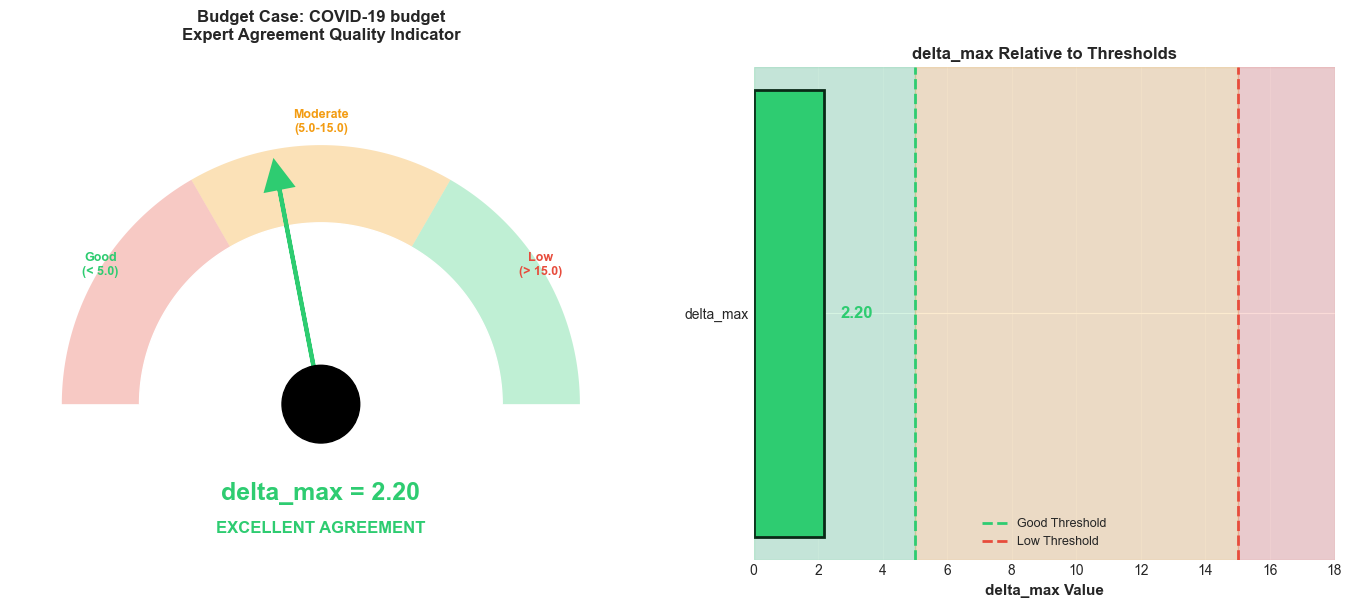

In [45]:
plot_accuracy_gauge(budget_result, "Budget Case: COVID-19 budget", "budget")

/var/folders/3f/31wd061j4kvc_mzd3wfvw8c00000gn/T/ipykernel_96988/2669144477.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = plt.Polygon(vertices, color=col, alpha=0.3, edgecolor=col, linewidth=0)


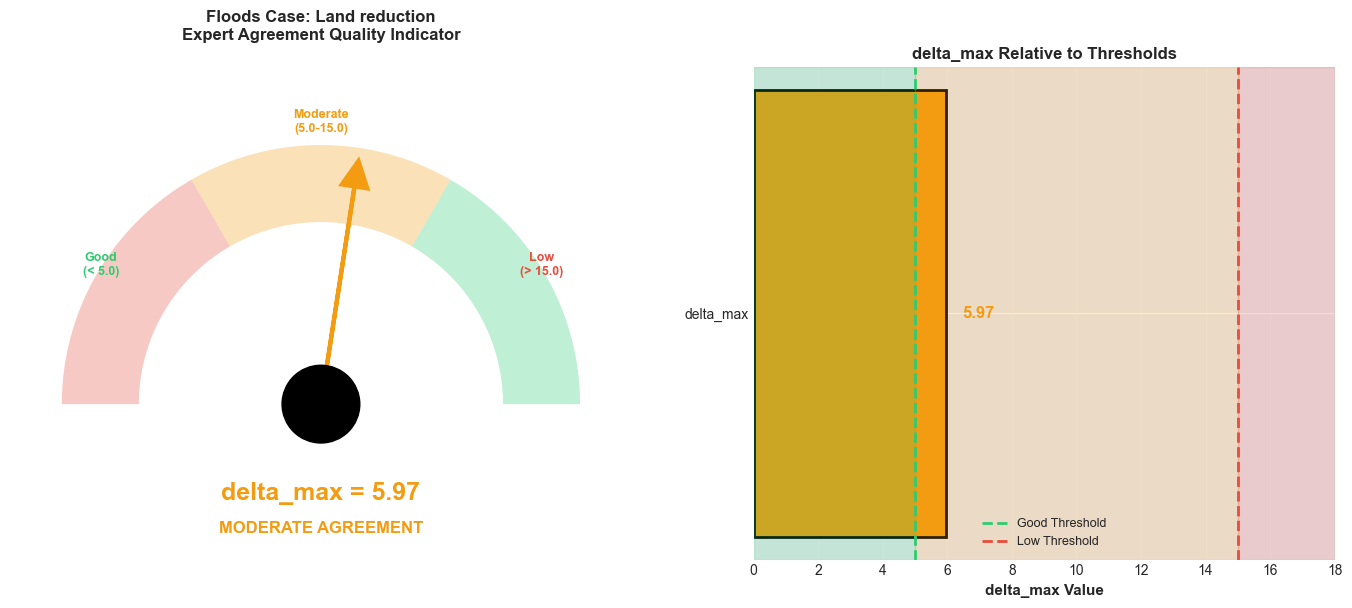

In [46]:
plot_accuracy_gauge(floods_result, "Floods Case: Land reduction", "floods")

/var/folders/3f/31wd061j4kvc_mzd3wfvw8c00000gn/T/ipykernel_96988/2669144477.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = plt.Polygon(vertices, color=col, alpha=0.3, edgecolor=col, linewidth=0)


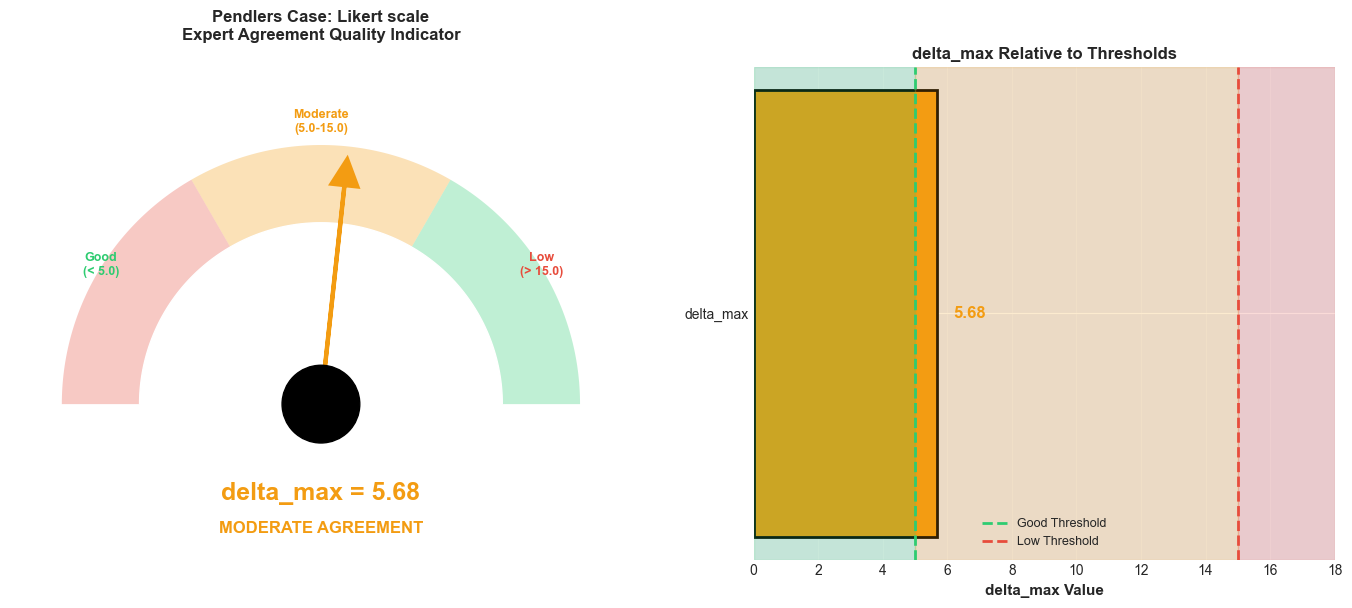

In [47]:
plot_accuracy_gauge(pendlers_result, "Pendlers Case: Likert scale", "pendlers")

## 8. Conclusions and Results Interpretation

### Budget Case
- Experts demonstrate relatively high agreement
- BeCoMe method effectively aggregates diverse opinions
- Compromise solution is within consensus zone

### Floods Case
- Greatest spread of opinions among all scenarios
- delta_max indicates need for additional discussion
- Visualizations help identify expert groups with different positions

### Pendlers Case
- Clear opinion clusters thanks to Likert scale
- Median and mean are close, indicating symmetric distribution
- Compromise well reflects group consensus

### General Observations
- BeCoMe method is robust to outliers (demonstrated in sensitivity analysis)
- Visualizations enable informed decision-making
- Interactive elements increase transparency of aggregation process

In [48]:
print("\n" + "=" * 80)
print("BECOME VISUALIZATIONS COMPLETED")
print("=" * 80)
print(f"\nCreated files in {output_dir}:")
print("  budget_membership_functions.png")
print("  budget_centroids.png")
print("  budget_heatmap.png")
print("  budget_accuracy_gauge.png")
print("  floods_membership_functions.png")
print("  floods_centroids.png")
print("  floods_heatmap.png")
print("  floods_accuracy_gauge.png")
print("  pendlers_membership_functions.png")
print("  pendlers_centroids.png")
print("  pendlers_heatmap.png")
print("  pendlers_accuracy_gauge.png")
print("  scenario_dashboard.png")
print("=" * 80)
print("\nAll visualizations successfully created!")
print("  Run this file in VS Code or Jupyter for interactive widgets")
print("=" * 80)


BECOME VISUALIZATIONS COMPLETED

Created files in /Users/katyabiser/Desktop/repos/BeCoMe/examples/visualizations/output:
  budget_membership_functions.png
  budget_centroids.png
  budget_heatmap.png
  budget_accuracy_gauge.png
  floods_membership_functions.png
  floods_centroids.png
  floods_heatmap.png
  floods_accuracy_gauge.png
  pendlers_membership_functions.png
  pendlers_centroids.png
  pendlers_heatmap.png
  pendlers_accuracy_gauge.png
  scenario_dashboard.png

All visualizations successfully created!
  Run this file in VS Code or Jupyter for interactive widgets
